# Imports

In [11]:
import os
import xml.etree.ElementTree as ET
import datetime
import string
import matplotlib.pyplot as plt
import tensorflow as tf

# For missing libraries, use following command:
# pip install -r src/requirements.txt

In [12]:
device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


I0000 00:00:1750674595.939498    3647 gpu_device.cc:2019] Created device /device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:05:00.0, compute capability: 8.6


# Graph tools

In [13]:
def plot_loss_and_time(loss, val_loss, total_time):
    epochs = range(1, len(loss) + 1)
    time_per_epoch = total_time / len(loss)
    time_per_epoch_list = [time_per_epoch.total_seconds()] * len(loss)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, loss, label='Training Loss', color='tab:blue', marker='o')
    ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange', marker='x')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Set x-axis ticks to integer epoch values only
    ax1.set_xticks(epochs)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Enable minor grid lines
    ax1.minorticks_on()
    ax1.grid(which='both', linestyle=':', linewidth=0.5)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Time per Epoch (s)', color=color)
    ax2.plot(epochs, time_per_epoch_list, label='Time per Epoch', color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('Loss and Time per Epoch')
    plt.show()

# Training Setup

## Environment

### Data source and training parameters

In [14]:
SOURCE = "labels_w"
'''Name of the dataset (used to build file paths for data input/output)'''

ARCHITECTURE = "flor"  
'''Model architecture to use (e.g., 'flor' for a specific network design)'''

EPOCHS = 5
'''Number of times the entire training dataset will be passed through the model'''

BATCH_SIZE = 64
'''Number of samples processed before the model is updated.

A larger batch size typically increases memory usage (since more data is loaded into memory at once) but can speed up training per epoch due to more efficient computation on modern hardware. However, very large batch sizes may require more GPU/CPU memory than available and can sometimes negatively impact model generalization. Smaller batch sizes use less memory and may generalize better, but training can be slower per epoch due to less efficient hardware utilization.
'''

'Number of samples processed before the model is updated.\n\nA larger batch size typically increases memory usage (since more data is loaded into memory at once) but can speed up training per epoch due to more efficient computation on modern hardware. However, very large batch sizes may require more GPU/CPU memory than available and can sometimes negatively impact model generalization. Smaller batch sizes use less memory and may generalize better, but training can be slower per epoch due to less efficient hardware utilization.\n'

### Data paths and charset

In [15]:
SOURCE_PATH = "data/" + f"{SOURCE}.hdf5"
'''Path to the input HDF5 dataset file'''

OUTPUT_PATH = "output/" + f"{SOURCE}/" + f"{ARCHITECTURE}/"
'''Directory for model outputs (checkpoints, logs, etc.)'''

CHECKPOINT_PATH = OUTPUT_PATH + "checkpoint_weights.weights.h5"
'''File path for saving/loading model checkpoint weights'''

INPUT_SIZE = (1024, 128, 1)
'''Model input image size (height, width, channels)'''

MAX_TEXT_LENGTH = 128
'''Maximum number of characters per text line'''

charset_base = string.printable[:95]
'''Set of valid characters for text recognition (base charset plus special characters)'''
charset_base = charset_base + "ČčĆćĐđŠšŽž"

os.makedirs(OUTPUT_PATH, exist_ok=True)
# Create a directory for the dataset if it doesn't exist

print("source:", SOURCE_PATH)
print("output:", OUTPUT_PATH)
print("checkpoint:", CHECKPOINT_PATH)
print("charset:", charset_base)

source: data/labels_w.hdf5
output: output/labels_w/flor/
checkpoint: output/labels_w/flor/checkpoint_weights.weights.h5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ČčĆćĐđŠšŽž


### DataGenerator Class

In [16]:
SRC_DIR_PATH = '/mnt/c/ETF/VI/AB_data_haris/vi-htr/src/'
# Add the source directory to the Python path to import local modules
# THIS IS REQUIRED!

import sys
if SRC_DIR_PATH not in sys.path:
    sys.path.append(SRC_DIR_PATH)

# Verify the path was added (optional)
print(sys.path)

from data.generator import DataGenerator

dtgen = DataGenerator(source=SOURCE_PATH,
                      batch_size=BATCH_SIZE,
                      charset=charset_base,
                      max_text_length=MAX_TEXT_LENGTH)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

['/home/haris/miniconda3/envs/TF-Py/lib/python312.zip', '/home/haris/miniconda3/envs/TF-Py/lib/python3.12', '/home/haris/miniconda3/envs/TF-Py/lib/python3.12/lib-dynload', '', '/home/haris/miniconda3/envs/TF-Py/lib/python3.12/site-packages', '/mnt/c/ETF/VI/AB_data_haris/vi-htr/src/']


KeyboardInterrupt: 

### HTRModel Class

In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
from network.model import HTRModel

# create and compile HTRModel
model = HTRModel(architecture=ARCHITECTURE,
                 input_size=INPUT_SIZE,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)
model.summary(OUTPUT_PATH, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=CHECKPOINT_PATH)

callbacks = model.get_callbacks(logdir=OUTPUT_PATH, checkpoint=CHECKPOINT_PATH, verbose=1)

I0000 00:00:1750673156.150408    3647 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:05:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1024, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 64, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 512, 64, 16)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 64, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d               │ (None, 512, 64, 16)    │         4,640 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 64, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 512, 64, 32)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_1             │ (None, 512, 64, 32)    │        18,496 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 16, 40)    │        10,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 256, 16, 40)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 16, 40)    │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_2             │ (None, 256, 16, 40)    │        28,880 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 16, 40)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 16, 48)    │        17,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 256, 16, 48)    │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 16, 48)    │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_3             │ (None, 256, 16, 48)    │        41,568 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 16, 48)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 4, 56)     │        21,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 256, 4, 56)     │            5

 Total params: 825,852 (3.15 MB)

 Trainable params: 825,340 (3.15 MB)

 Non-trainable params: 512 (2.00 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1024, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 64, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 512, 64, 16)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 64, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d               │ (None, 512, 64, 16)    │         4,640 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 64, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 512, 64, 32)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_1             │ (None, 512, 64, 32)    │        18,496 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 16, 40)    │        10,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 256, 16, 40)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 16, 40)    │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_2             │ (None, 256, 16, 40)    │        28,880 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 16, 40)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 16, 48)    │        17,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 256, 16, 48)    │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 16, 48)    │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_3             │ (None, 256, 16, 48)    │        41,568 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 16, 48)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 4, 56)     │        21,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 256, 4, 56)     │            5

 Total params: 825,852 (3.15 MB)

 Trainable params: 825,340 (3.15 MB)

 Non-trainable params: 512 (2.00 KB)

/home/haris/miniconda3/envs/TF-Py/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Training

Epoch 1/5


E0000 00:00:1750673164.817910    3647 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1750673165.784178    3748 cuda_dnn.cc:529] Loaded cuDNN version 90300


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - loss: 0.9285
Epoch 1: val_loss improved from inf to 1.26948, saving model to output/labels_w/flor/checkpoint_weights.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 123s 717ms/step - loss: 0.9284 - val_loss: 1.2695 - learning_rate: 0.0010
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - loss: 0.8185
Epoch 2: val_loss improved from 1.26948 to 1.26856, saving model to output/labels_w/flor/checkpoint_weights.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 72s 567ms/step - loss: 0.8187 - val_loss: 1.2686 - learning_rate: 0.0010
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - loss: 0.7527
Epoch 3: val_loss did not improve from 1.26856
127/127 ━━━━━━━━━━━━━━━━━━━━ 71s 558ms/step - loss: 0.7532 - val_loss: 1.2779 - learning_rate: 0.0010
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 0.7901
Epoch 4: val_loss improved from 1.26856 to 1.18924, saving model to output/labels_w/flor/checkpoint_weights.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 70

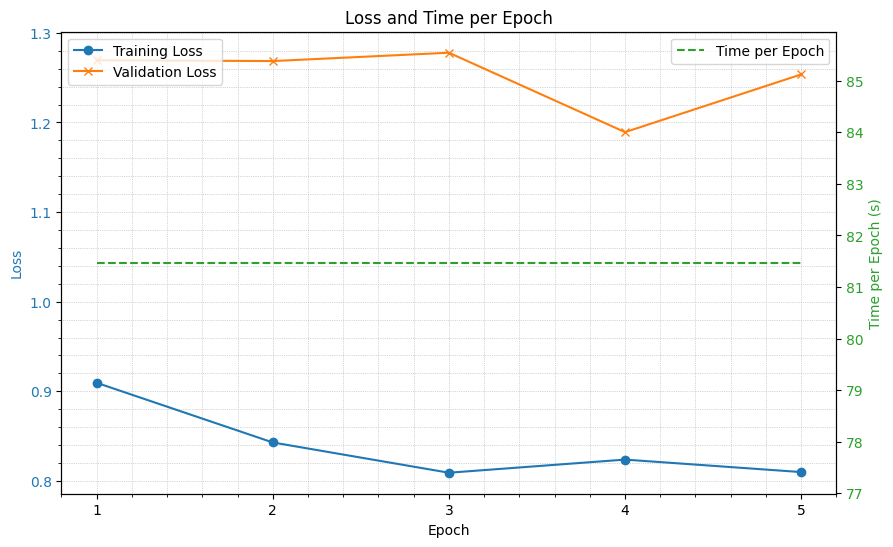

Total train images:      8116
Total validation images: 2319
Batch:                   64

Total time:              0:06:47.354904
Time per epoch:          0:01:21.470981
Time per item:           0:00:00.007807

Total epochs:            5
Best epoch               4

Training loss:           0.82373452
Validation loss:         1.18923628


In [ ]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=EPOCHS,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

plot_loss_and_time(loss, val_loss, total_time)

with open(os.path.join(OUTPUT_PATH, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

# Predict

In [ ]:
import cv2
from src.data.preproc import adjust_to_see
import datetime

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(OUTPUT_PATH, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2.imshow("Prediction", adjust_to_see(item))
    print(ground_truth[i])
    print(predicts[i], "\n")
    cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'datetime' is not defined

# Evaluation

In [ ]:
from src.data.evaluation import ocr_metrics

# At this point, you already have your predictions and ground truth:
# predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
# ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

# Calculate metrics
cer, wer, ser, char_acc, word_acc, seq_acc = ocr_metrics(predicts, ground_truth)

# Print results
print(f"Character Error Rate: {cer:.4f}")
print(f"Word Error Rate:      {wer:.4f}")
print(f"Sequence Error Rate:  {ser:.4f}")
print(f"Character Accuracy:   {char_acc:.4f}")
print(f"Word Accuracy:        {word_acc:.4f}")
print(f"Sequence Accuracy:    {seq_acc:.4f}")

# Optionally, save to file
e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Character Error Rate: {cer:.8f}",
    f"Word Error Rate:      {wer:.8f}",
    f"Sequence Error Rate:  {ser:.8f}",
    f"Character Accuracy:   {char_acc:.8f}",
    f"Word Accuracy:        {word_acc:.8f}",
    f"Sequence Accuracy:    {seq_acc:.8f}"
])

with open(os.path.join(OUTPUT_PATH, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

<class 'tuple'> 1
(array([[[[0.34250632],
         [0.34250632],
         [0.34250632],
         ...,
         [0.34250632],
         [0.34250632],
         [0.34250632]],

        [[0.34250632],
         [0.34250632],
         [0.34250632],
         ...,
         [0.34250632],
         [0.34250632],
         [0.34250632]],

        [[0.34250632],
         [0.34250632],
         [0.34250632],
         ...,
         [0.34250632],
         [0.34250632],
         [0.34250632]],

        ...,

        [[0.34250632],
         [0.34250632],
         [0.34250632],
         ...,
         [0.34250632],
         [0.34250632],
         [0.34250632]],

        [[0.34250632],
         [0.34250632],
         [0.34250632],
         ...,
         [0.34250632],
         [0.34250632],
         [0.34250632]],

        [[0.34250632],
         [0.34250632],
         [0.34250632],
         ...,
         [0.34250632],
         [0.34250632],
         [0.34250632]]],


       [[[0.17037712],
         [0.170377